# 0. Preliminaries

- 라이브러리 import
- 전처리
- train/val split
- device 세팅


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ai-vs-human-generated-dataset' dataset.
Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [18]:
import torch
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sns
import cv2

import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import f1_score,accuracy_score

In [19]:
#train,test 데이터셋 불러오기
train=pd.read_csv(os.path.join(path,'train.csv'))
test=pd.read_csv(os.path.join(path,'test.csv'))

#데이터가 있는 폴더 경로
root=os.path.join(path)
print(root)

/kaggle/input/ai-vs-human-generated-dataset


In [20]:
#None값 있는지 확인-> 없음
print(train["label"].isnull().any())
print(train['file_name'].isnull().any())

train=train.drop(columns=['Unnamed: 0']) #필요없는 열 제거

False
False


In [21]:
#train/val split
train_df,val_df=train_test_split(train,test_size=0.2, stratify=train['label'])

In [22]:
#device 세팅
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

device=torch.device(device)
print('Using device:',device)

Using device: cuda


# 1. Summary of Configuration and Data Status

구성 요소가 제대로 작동하는지 확인

In [23]:
#전처리 완료
print("--- 전처리 확인 ---")
print(train.head())

# train, test split 확인
print("\n--- split 확인 ---")
print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of val_df: {val_df.shape}")
print("\nLabel distribution in train_df:")
display(train_df['label'].value_counts(normalize=True))
print("Label distribution in val_df:")
display(val_df['label'].value_counts(normalize=True))

#device 세팅
print("\n--- device 세팅 확인 ---")
print('Using device:',device)

--- 전처리 확인 ---
                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1

--- split 확인 ---
Shape of train_df: (63960, 2)
Shape of val_df: (15990, 2)

Label distribution in train_df:


,proportion
label,
0,0.5
1,0.5


Label distribution in val_df:


,proportion
label,
1,0.5
0,0.5



--- device 세팅 확인 ---
Using device: cuda


#### 1. 데이터셋 개요 (Dataset Description)

이미지의 진위 여부를 판별하는 **이미지 위변조 탐지(Image Authenticity Detection)** 모델 데이터셋

1.1 데이터 구성 및 특징
* **Authentic vs Generated:**
  - Shutterstock 플랫폼에서 수집된 실제 이미지(Authentic)
  - 최신 SOTA(State-of-the-art) 생성 모델을 통해 만들어진 생성 이미지(AI-generated)

* **Paired Data:** 실제 이미지와 이에 대응하는 생성 이미지가 쌍(Pair)을 이루고 있음
* **Category Balance:**
  - 다양한 카테고리의 이미지를 포함
  - 전체 데이터의 약 1/3은 인물(Humans)이 포함된 이미지

1.2 파일 상세 정보

* **train.csv**: 훈련 데이터셋 (총 **79,950**장)
* **test.csv**: 테스트 데이터셋 (총 **19,986**장)

# 2. Model Definition and Training Execution

- RGB 도메인과 주파수 도메인의 특징을 통합하는 앙상블 학습(Ensemble Learning) 구조를 구축
- 최적화 기법을 적용하여 모델을 훈련



주요 내용
* **Data Augmentation**: 훈련 데이터셋에는 이미지 증강 및 AI 아티팩트 모방 변환 (Salt&Pepper 노이즈, JPEG 압축)을 다양하게 적용하여 모델의 일반화 성능을 강화합니다.
* **Domain Separation**: 각 샘플에서 RGB 이미지 텐서와 DCT 변환 기반 주파수 특징 텐서를 동시에 추출하여 앙상블 모델에 입력
* **RGB Feature Extractor (ConvNext)**: 사전 훈련된 ConvNeXt Base 모델로 전이학습
* **DeeperFrequencyCNN**: DCT 변환으로 얻어진 주파수 도메인 특징을 입력받아 AI 이미지 특유의 고주파 아티팩트를 탐지하도록 설계된 깊은 CNN 구조를 정의
* **Ensemble Model**: 두 특징 추출기가 반환한 128차원 특징 벡터를 결합
* **Optimizer**: AdamW 옵티마이저, Weight Decay(과적합 방지)
* **Loss Function**: Label Smoothing 이용한 Cross Entropy Loss

In [24]:
def apply_dct(image_pil, size=(224, 224)):
    """
    PIL Image를 받아 DCT 변환 후 정규화하여 3채널 텐서(3, H, W)를 반환합니다.
    """
    # 1. 크기 조정 (RGB 이미지의 최종 크기인 224x224에 맞춥니다)
    #    DCT는 RandomCrop 등의 증강이 없는, 결정적인 입력이 필요합니다.
    image_np = np.array(image_pil.resize(size))
    dct_channels = []

    for i in range(3): # R, G, B 각 채널에 대해 DCT 적용
        channel = image_np[:, :, i]

        # 2. DCT 변환 및 로그 스케일링
        dct_transformed = cv2.dct(np.float32(channel))
        # 노이즈를 포함한 AI 아티팩트 특성 강화를 위해 로그 스케일링
        dct_display = np.log(np.abs(dct_transformed) + 1e-8)

        # 3. 0-1 정규화 (CNN이 학습하기 쉬운 범위로 스케일 조정)
        min_val = dct_display.min()
        max_val = dct_display.max()
        if max_val > min_val:
            dct_display = (dct_display - min_val) / (max_val - min_val)
        else: # 엣지 케이스 처리 (모두 같은 값일 경우)
            dct_display = np.zeros_like(dct_display)

        dct_channels.append(dct_display)

    # 4. (3, H, W) 형태의 NumPy 배열 생성 후 PyTorch 텐서로 변환
    dct_output = np.stack(dct_channels, axis=0) # 최종 형태: (3, H, W)
    return torch.from_numpy(dct_output).float()

In [25]:
# [수정된 ImageDataset 클래스]
class ImageDataset(Dataset):
    def __init__(self, root, df, transform=None, is_train=True):
        self.root = root
        self.df = df
        self.transform = transform
        self.is_train = is_train
        # RGB 이미지의 최종 크기 (DCT에도 동일하게 적용)
        self.target_size = (224, 224)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        img_path = os.path.join(self.root, img_path)
        image = Image.open(img_path).convert('RGB')

        # 1. 주파수 이미지 생성 (apply_dct는 이미 텐서로 변환하여 (3, 224, 224) 반환)
        # DCT 입력은 RGB 이미지 증강 전의 결정적인 (224, 224) 크기여야 합니다.
        freq_image = apply_dct(image, size=self.target_size)

        # 2. RGB 이미지 전처리 (Random Crop 등의 증강 적용)
        if self.transform:
            rgb_image = self.transform(image)

        if self.is_train:
            label = self.df.iloc[idx, 1]
            return rgb_image, freq_image, label
        else:
            return rgb_image, freq_image

# 코드 추가 (증강 다양화)
class GaussianNoiseTransform(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0., 1.)

class SaltPepperNoise(object):
    def __init__(self, amount=0.02, s_vs_p=0.5):
        self.amount = amount
        self.s_vs_p = s_vs_p

    def __call__(self, img):
        img = np.array(img).astype(np.float32) / 255.0
        noisy = np.copy(img)

        num_salt = np.ceil(self.amount * img.size * self.s_vs_p)
        coords = tuple(np.random.randint(0, i - 1, int(num_salt)) for i in img.shape)
        noisy[coords] = 1

        num_pepper = np.ceil(self.amount * img.size * (1. - self.s_vs_p))
        coords = tuple(np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape)
        noisy[coords] = 0

        noisy = (noisy * 255).astype(np.uint8)
        return Image.fromarray(noisy)

import io
from PIL import Image

class JpegCompression(object):
    def __init__(self, quality=70):
        self.quality = quality

    def __call__(self, img):
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=self.quality)
        buffer.seek(0)
        return Image.open(buffer)

# [CNN에 이미지를 넣기 전 전처리&데이터 증강 수행]
train_transforms = transforms.Compose([
    transforms.Resize(232),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),

    transforms.RandomAutocontrast(p=0.3),
    transforms.RandomAdjustSharpness(2, p=0.3),
    transforms.GaussianBlur(3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    SaltPepperNoise(amount=0.02),
    JpegCompression(quality=70),

    transforms.ToTensor(),
    GaussianNoiseTransform(std=0.05),

    transforms.RandomErasing(p=0.3),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

import random
import numpy as np
from PIL import Image

val_test_transforms = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224), # 최종 RGB 크기는 224x224
    transforms.ToTensor(), # 이미지를 PyTorch Tensor형식으로 바꿈
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
# class FrequencyCNN(nn.Module):
#     def __init__(self, num_features=128): # 앙상블을 위해 128차원 feature 벡터 반환
#         super(FrequencyCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 입력: (3, 224, 224)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.3)

#         # 입력 이미지 크기 (224, 224) 기준: 224 -> 112 (pool1) -> 56 (pool2)
#         # 최종 Flatten 크기: 32 * 56 * 56
#         self.fc1 = nn.Linear(32 * 56 * 56, 128)
#         self.fc2 = nn.Linear(128, num_features) # num_features (128)로 변경

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x)))) # (B, 16, 112, 112)
#         x = self.dropout(x)
#         x = self.pool(F.relu(self.bn2(self.conv2(x)))) # (B, 32, 56, 56)
#         x = self.dropout(x)

#         # Flatten
#         x = x.view(x.size(0), -1)

#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x) # (Batch, 128)
#         return x

# [FrequencyCNN 강화 코드 예시]
# 레이어의 깊이를 늘리고, 채널 수를 증가
# 정규화 기법을 강화하여 주파수 도메인 특징 추출 능력을 향상
class DeeperFrequencyCNN(nn.Module):
    def __init__(self, num_features=128):
        super(DeeperFrequencyCNN, self).__init__()
        # 초기 레이어 (224 -> 112)
        self.layer1 = self._make_layer(3, 32)
        # 중간 레이어 (112 -> 56)
        self.layer2 = self._make_layer(32, 64)
        # 추가 레이어 (56 -> 28)
        self.layer3 = self._make_layer(64, 128)

        # 최종 Flatten 크기: 128 * 28 * 28
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_features) # 128차원 출력 유지
        )

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4) # 정규화 강화
        )

    def forward(self, x):
        x = self.layer1(x) # (B, 32, 112, 112)
        x = self.layer2(x) # (B, 64, 56, 56)
        x = self.layer3(x) # (B, 128, 28, 28)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# [앙상블 모델 클래스] - (기존 코드와 동일하며 Feature 크기 128 통일)
class EnsembleModel(nn.Module):
    def __init__(self, rgb_model, freq_model):
        super(EnsembleModel, self).__init__()
        self.rgb_model = rgb_model
        self.freq_model = freq_model

        # 두 벡터를 합친 후(128 + 128 = 256) 최종 분류
        self.final_classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2) # 최종 Binary Classification (AI vs Real)
        )

    def forward(self, rgb_img, freq_img):
        rgb_feat = self.rgb_model(rgb_img)  # (Batch, 128)
        freq_feat = self.freq_model(freq_img) # (Batch, 128)

        # 두 특징 벡터 결합 (Concatenate)
        combined = torch.cat((rgb_feat, freq_feat), dim=1)
        output = self.final_classifier(combined)
        return output

## 3. 데이터 로딩 및 초기화 + 모델 학습

In [27]:
# [데이터 로딩 및 초기화]

BATCH_SIZE = 32
NUM_WORKERS = 2

#라벨이 있는 훈련 이미지
train_dataset = ImageDataset(root, train_df, transform=train_transforms)
#라벨이 있는 검증 이미지
val_dataset = ImageDataset(root, val_df, transform=val_test_transforms)
#라벨 없는 테스트 이미지 (테스트 시에는 val_test_transforms 사용)
test_dataset = ImageDataset(root, test, transform=val_test_transforms, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


# [모델 초기화 및 옵티마이저]
rgb_backbone = models.convnext_base(weights="DEFAULT")

# ConvNext Backbone 동결 및 Classifier 수정 (Feature 128차원 반환)
for param in rgb_backbone.features.parameters():
    param.requires_grad = False
for param in rgb_backbone.features[-2:].parameters():
    param.requires_grad = True

rgb_backbone.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 128) # 최종 출력을 128차원 Feature 벡터로 변경
)

# freq_net = FrequencyCNN(num_features=128)
freq_net = DeeperFrequencyCNN(num_features=128)
model = EnsembleModel(rgb_backbone, freq_net)
model = model.to(device)

# # 옵티마이저 설정 (차등 학습률 적용)
# optimizer = torch.optim.AdamW([
#     {'params': model.rgb_model.features[-2:].parameters(), 'lr': 1e-5}, # ConvNext 마지막 블록만 낮은 학습률
#     {'params': model.rgb_model.classifier.parameters(), 'lr': 1e-4},
#     {'params': model.freq_model.parameters(), 'lr': 1e-3}, # 새로 만든 CNN은 높은 학습률
#     {'params': model.final_classifier.parameters(), 'lr': 1e-3} # 분류 레이어도 높은 학습률
# ])

# [수정된 옵티마이저]
optimizer = torch.optim.AdamW([
    {'params': model.rgb_model.features[-2:].parameters(), 'lr': 1e-5},
    {'params': model.rgb_model.classifier.parameters(), 'lr': 1e-4},
    {'params': model.freq_model.parameters(), 'lr': 1e-3},
    {'params': model.final_classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-4) #weight_decay 추가

import numpy as np

# train DataFrame에서 label 분포 확인 (0,1 순서로 정렬)
class_counts = train['label'].value_counts().sort_index().values.astype(np.float32)
# 예: [1789., 3751.] 이런 식

num_classes = 2
total = class_counts.sum()

# 간단한 balanced weight: w_c = total / (num_classes * count_c)
class_weights = total / (num_classes * class_counts)

print("class_weights (for labels 0,1):", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# criterion=nn.CrossEntropyLoss()

# (class weight + label smoothing 둘 다 적용)
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.05
)

scheduler=StepLR(optimizer,step_size=5, gamma=0.7)



class_weights (for labels 0,1): [1. 1.]


In [28]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 시드 고정

In [29]:
# [학습 함수]
def train(model, optimizer, loss_fn, dataloader, scheduler=None):
    num_batches = len(dataloader)
    model.train()

    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for rgb, freq, y in tqdm(dataloader):
        rgb, freq, y = rgb.to(device), freq.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(rgb, freq) # 앙상블 모델에 RGB와 Freq 이미지 모두 전달
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = outputs.argmax(dim=1)
        acc = (preds == y).float().mean().item()
        epoch_accuracy += acc

    epoch_loss /= num_batches
    epoch_accuracy /= num_batches

    # 스케줄러는 에폭 후 호출 (StepLR의 경우)
    if scheduler:
        # StepLR 같은 경우, train 함수 외부의 main loop에서 호출하는 것이 일반적입니다.
        # 여기서는 주석 처리하고 main loop에서 호출하도록 하겠습니다.
        pass

    return epoch_loss, epoch_accuracy

# [검증 함수]
def validate(model, loss_fn, dataloader):
    num_batches = len(dataloader)
    model.eval()

    val_loss = 0.0
    val_acc = 0.0
    val_pred_classes = []
    val_y = []

    with torch.no_grad():
        for rgb, freq, y in tqdm(dataloader):
            rgb, freq, y = rgb.to(device), freq.to(device), y.to(device)
            outputs = model(rgb, freq) # 앙상블 모델에 RGB와 Freq 이미지 모두 전달

            loss = loss_fn(outputs, y)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            acc = (preds == y).float().mean().item()
            val_acc += acc

            val_pred_classes.extend(preds.cpu().numpy())
            val_y.extend(y.cpu().numpy())

    val_loss /= num_batches
    val_acc /= num_batches
    val_f1 = f1_score(np.array(val_y), np.array(val_pred_classes), average='binary')

    return val_loss, val_acc, val_f1


# [학습 루프]
n_epochs = 5 #7, 10, 15
train_loss, train_acc = [], []
val_loss, val_acc, val_f1 = [], [], []
best_val_f1 = 0.0
best_model_path = "best_ensemble_model.pth" # 파일명 변경

print("--- Start Training ---")
for epoch in range(n_epochs):
    loss, acc = train(model, optimizer, criterion, train_loader)
    train_loss.append(loss)
    train_acc.append(acc)

    loss, acc, f1 = validate(model, criterion, val_loader)
    val_loss.append(loss)
    val_acc.append(acc)
    val_f1.append(f1)

    # StepLR 스케줄러 호출
    scheduler.step()

    print(f'Epoch {epoch+1} (LR: {optimizer.param_groups[0]["lr"]:.6f}):')
    print(f'\t train_loss: {train_loss[epoch]:.4f}, train_acc: {train_acc[epoch]:.4f}')
    print(f'\t val_loss: {val_loss[epoch]:.4f}, val_acc: {val_acc[epoch]:.4f}, val_f1: {val_f1[epoch]:.4f}\n')

    if f1 > best_val_f1:
        best_val_f1 = f1
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_f1': best_val_f1
        }, best_model_path)
        print(f"✓ Best model saved! (F1: {best_val_f1:.4f})")

--- Start Training ---


100%|██████████| 500/500 [05:15<00:00,  1.59it/s]


Epoch 1 (LR: 0.000010):
	 train_loss: 0.5252, train_acc: 0.7552
	 val_loss: 0.6670, val_acc: 0.7002, val_f1: 0.7681

✓ Best model saved! (F1: 0.7681)


100%|██████████| 500/500 [05:38<00:00,  1.48it/s]


Epoch 2 (LR: 0.000010):
	 train_loss: 0.3664, train_acc: 0.8693
	 val_loss: 0.6695, val_acc: 0.6968, val_f1: 0.7664



100%|██████████| 500/500 [04:48<00:00,  1.73it/s]


Epoch 3 (LR: 0.000010):
	 train_loss: 0.3529, train_acc: 0.8757
	 val_loss: 0.5365, val_acc: 0.7926, val_f1: 0.8264

✓ Best model saved! (F1: 0.8264)


100%|██████████| 500/500 [04:39<00:00,  1.79it/s]


Epoch 4 (LR: 0.000010):
	 train_loss: 0.3466, train_acc: 0.8796
	 val_loss: 0.5785, val_acc: 0.7453, val_f1: 0.7961



100%|██████████| 500/500 [04:37<00:00,  1.80it/s]

Epoch 5 (LR: 0.000007):
	 train_loss: 0.3379, train_acc: 0.8844
	 val_loss: 0.5798, val_acc: 0.7818, val_f1: 0.8198



## 4. Test

In [33]:
predicted_classes = []

# torch.no_grad 블록 외부에서 test_id 리스트를 준비합니다.
# test DataFrame은 이전에 로드되었다고 가정합니다. (test = pd.read_csv(...))
# test_ids = test['id'].tolist()

# model.eval()
# with torch.no_grad():
#     # X 대신 rgb, freq 두 변수로 튜플을 분리하여 받습니다.
#     for rgb, freq in test_loader:

#         # 각각의 텐서를 device로 이동시킵니다.
#         rgb = rgb.to(device)
#         freq = freq.to(device)

#         # 앙상블 모델에 두 입력을 모두 전달합니다.
#         outputs = model(rgb, freq)

#         # 예측 클래스 추출
#         preds = outputs.argmax(dim=1)

#         # 결과를 리스트에 추가
#         predicted_classes.extend(preds.cpu().numpy())

threshold = 0.3  # 예: 30% 이상일 경우 Label 1로 판단
# ------------------------------------------------------------
probs_list = []
predicted_classes = []
test_ids = test['id'].tolist()

model.eval()
with torch.no_grad():
    for rgb, freq in tqdm(test_loader): # tqdm 추가하면 진행상황 보여서 좋습니다
        rgb = rgb.to(device)
        freq = freq.to(device)

        outputs = model(rgb, freq)

        # [수정 전] 단순히 가장 높은 값 선택 (0.5 기준)
        # preds = outputs.argmax(dim=1)

        # [수정 후] 확률을 계산하여 Threshold 적용
        # 1. Logits를 확률(0~1)로 변환
        probs = torch.softmax(outputs, dim=1)

        # 2. Class 1(양성 클래스)에 대한 확률만 추출
        prob_class_1 = probs[:, 1]

        # 3. Threshold보다 크면 1, 아니면 0으로 변환
        probs_list.extend(prob_class_1.cpu().numpy())
        preds = (prob_class_1 >= threshold).long()

        predicted_classes.extend(preds.cpu().numpy())


# 제출 파일 생성
ss = pd.DataFrame({
    # test_loader는 shuffle=False이므로 순서가 test DataFrame과 일치합니다.
    'id': test_ids,
    'label': predicted_classes
})

ss.to_csv('submission.csv', index=False)

print("submission.csv 파일이 성공적으로 생성되었습니다.")

# Google Drive에 저장하도록 경로 수정
drive_path = '/content/drive/MyDrive/CV/' # Drive 내부에 원하는 폴더명으로 수정 가능
file_name = 'submission.csv'

# 폴더가 없으면 생성 (선택 사항, 에러 방지용)
import os
os.makedirs(drive_path, exist_ok=True)

# 제출 파일 생성
ss = pd.DataFrame({
    # test_loader는 shuffle=False이므로 순서가 test DataFrame과 일치합니다.
    'id': test_ids,
    'label': predicted_classes
})

# Google Drive 경로에 저장
ss.to_csv(os.path.join(drive_path, file_name), index=False)

print(f"Threshold {threshold}가 적용된 submission 파일이 저장되었습니다.")

100%|██████████| 174/174 [03:33<00:00,  1.23s/it]


submission.csv 파일이 성공적으로 생성되었습니다.
Threshold 0.3가 적용된 submission 파일이 저장되었습니다.


In [34]:
df_final = pd.read_csv("/content/drive/MyDrive/CV/submission.csv")

print(df_final['label'].value_counts())

label
1    4446
0    1094
Name: count, dtype: int64


In [39]:
threshold = 0.75

# 설정한 threshold보다 크면 1, 작으면 0
predicted_classes = (np.array(probs_list) >= threshold).astype(int)

# 결과 분포 즉시 확인
print(f"\n=== Threshold: {threshold} 적용 결과 ===")
df_temp = pd.DataFrame({'label': predicted_classes})
print(df_temp['label'].value_counts())


=== Threshold: 0.75 적용 결과 ===
label
1    3375
0    2165
Name: count, dtype: int64


#### 성능

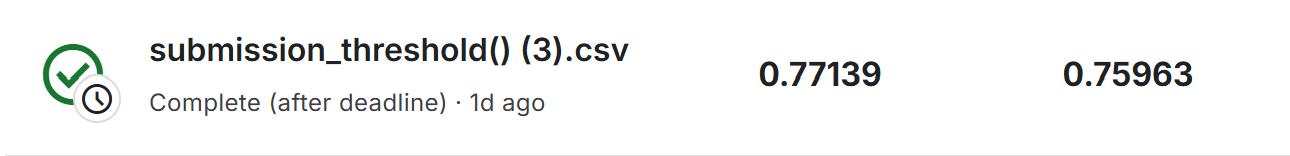

https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images/data
- 캐글 리더보드 기준 40-50위
- Private Score : 0.77139